https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


##### Reading in the data

In [238]:
df = pd.read_csv("bar_pass_prediction.csv")
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [239]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the unprocessed dataset")
df.head()


There are 22407 rows and 39 columns in the unprocessed dataset


,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


There seems to be many columns in this dataset which are either useless or copies/transformations of other columns.
This notebook will therefore focus heavily on processing the data.

#### Columns I decided to drop

The variable names are not straightforward but a Kaggle user had described some of them here: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage/discussion/350765 which I will be using as a loose guide along with my own analysis


Based on the initial description, these are the columns I will be dropping for sure:

- dnn_bar_pass_prediction (Models prediction of whether or not the student will pass)
- Cluster -> was unable to find a description and I had no idea what this represented when I looked at the data
- index6040, indxgrp and indexgrp2 -> Again it was very unclear what these columns represented
- gpa, zgpa, zfygpa - These values are completely correlated with UGPA which corresponds to a students undergraduate GPA so there was no point in keeping them
- bar1, bar1_yr, bar2, bar2_yr, bar_passed -> Again, these columns just gives us (a bit more nuanced) information about whether a student passed or not.
- race, race2, asian, black, hisp -> We can just use the race1. All other variation were more lacking in the sense that there are missing values
- Dropout -> This is just a column consisting of zeroes
- parttime -> There is another column named "full-time" which correlated perfectly with parttime so I decided to drop parttime
- age  -> There are many negativie values present which doesn't make sense for age (this is confirmed in the code below)
- male, sex -> this information is already in the gender column



In [240]:
negative_count = (df['age'] < 0).sum()
negative_count

22318

In [241]:

columns_to_drop = [
    'dnn_bar_pass_prediction',
    'cluster',
    'index6040', 'indxgrp', 'indxgrp2',
    'gpa', 'zgpa', 'zfygpa',
    'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'bar_passed',
    'race', 'race2', 'asian', 'black', 'hisp',
    'Dropout',
    'parttime',
    'age',
    'male', 'sex', 'other',
    'ID'
]

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')



#### Columns I decided to keep

The remaining columns that are left can be described as follow:

- decile1, decile1b, decile3 -> Describes the law school ranking by decile of each candidate in year 1 (semester 1, semester 2) and year 3. I'm not sure why the remaining years are not included though.
- lsat -> The LSAT score of each candidate (although it has been altered somehow as it's not within the normal range, but it still correlated with the target (passed/not passed) as seen in the code below so therefore I decided to keep it)
- grad - This is a binary column describing whether a student graduated or not
- fulltime -> If the student a full-time student.
- fam_inc -> Family income by quintile.
- tier -> What tier law school did the student attend by quintile.
- race1 -> The race of the student.
- sex -> the gender of the student.
- pass_bar -> This is the target variable. Did the student pass the bar.









So after these adjustments, the dataframe looks as follows:







In [242]:
df.head()

,decile1b,decile3,decile1,lsat,ugpa,DOB_yr,grad,fulltime,fam_inc,gender,race1,pass_bar,bar,tier
0,10.0,10.0,10.0,44.0,3.5,69.0,Y,1.0,5.0,female,white,1,a Passed 1st time,4.0
1,5.0,4.0,5.0,29.0,3.5,69.0,Y,1.0,4.0,female,white,1,a Passed 1st time,2.0
2,3.0,2.0,3.0,36.0,3.5,65.0,Y,1.0,1.0,male,white,1,a Passed 1st time,3.0
3,7.0,4.0,7.0,39.0,3.5,58.0,Y,1.0,4.0,male,white,1,a Passed 1st time,3.0
4,9.0,8.0,9.0,48.0,3.5,68.0,Y,1.0,4.0,male,white,1,a Passed 1st time,5.0


#### Missing values

In [243]:
# Checking for null values across all columns
df.isnull().sum()


decile1b    1604
decile3     1604
decile1     1092
lsat           0
ugpa           0
DOB_yr        50
grad           3
fulltime      34
fam_inc      289
gender         5
race1         16
pass_bar       0
bar            0
tier          96
dtype: int64

There seems to be quite a few missing values across many columns. I will deal with those in the cell below by replace NaN with mean for numeric columns, and mode for categorical columns

In [244]:
import numpy as np

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Display identified columns
print("Numeric columns:")
print(numeric_cols)
print("\nCategorical columns:")
print(categorical_cols)

# Fill missing values based on data type and context
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that all missing values are filled
missing_counts_after = df.isnull().sum()
print("\nMissing Value Counts after filling:")
print(missing_counts_after)

Numeric columns:
['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'fulltime', 'fam_inc', 'pass_bar', 'tier']

Categorical columns:
['grad', 'gender', 'race1', 'bar']

Missing Value Counts after filling:
decile1b    0
decile3     0
decile1     0
lsat        0
ugpa        0
DOB_yr      0
grad        0
fulltime    0
fam_inc     0
gender      0
race1       0
pass_bar    0
bar         0
tier        0
dtype: int64


/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_83299/2558248060.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_83299/2558248060.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

## EDA

##### First I will plot the distribution of passed student 

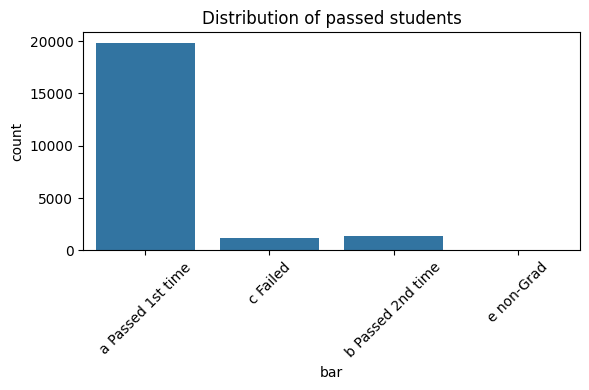

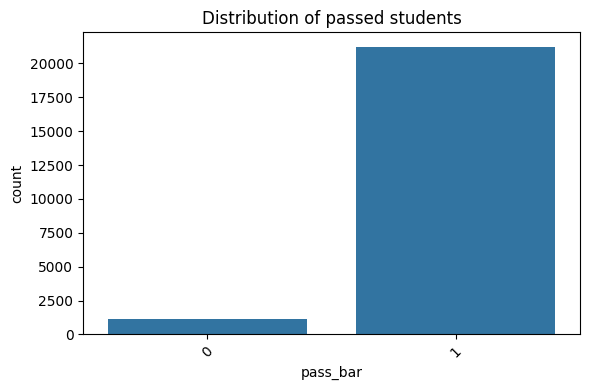

In [245]:
# Plotting the overall distribution of the target column
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=df['bar'])
plt.title(f'Distribution of passed students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=df['pass_bar'])
plt.title(f'Distribution of passed students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


From this we see that there is a quite uneven class distribution

##### EDA into the protected features: Race and Sex

Counting the distribution of different genders and races

In [246]:
df['gender'].value_counts()


gender
male      12581
female     9826
Name: count, dtype: int64

In [247]:
df['race1'].value_counts()


race1
white    18732
black     1343
hisp      1027
asian      897
other      408
Name: count, dtype: int64

We see that there are more men by about 12 percent and the amount of white students are generally about 80 percent more in comparison to each other individual race

Now let's visualise the pass rate in relation to sex and race:

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_83299/2679575959.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:


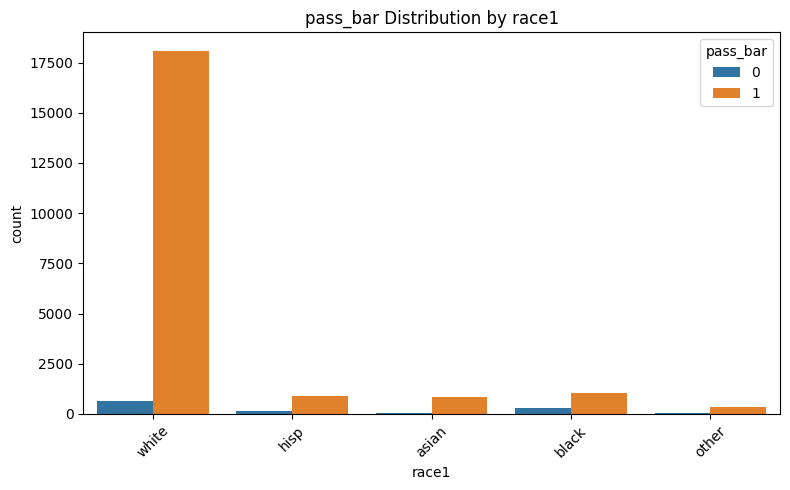

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_83299/2679575959.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:


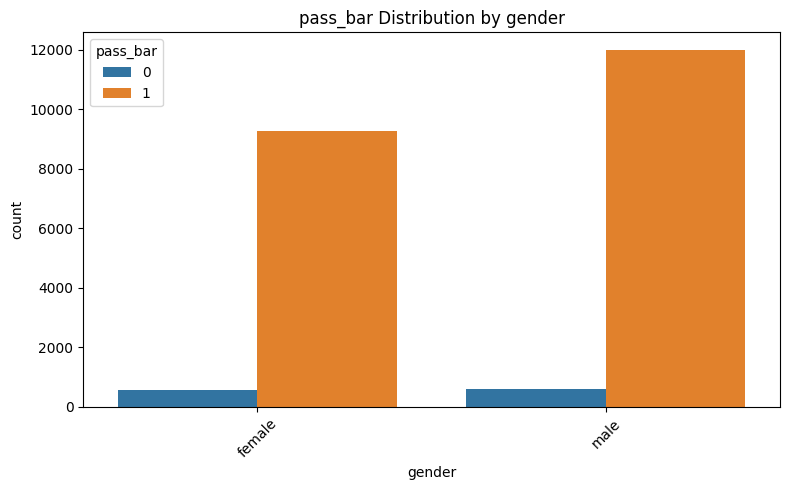

In [248]:


def visualize_columns(df, columns, target):

    # Iterate through each column in the list
    for col in columns:
        plt.figure(figsize=(8, 5))
        
        # Plotting the relationship between target and each column
        if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:
            sns.countplot(data=df, x=col, hue=target)
        else:
            sns.histplot(data=df, x=col, hue=target, multiple="stack", kde=False)
        
        plt.title(f'{target} Distribution by {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage
# Assuming df is your DataFrame and you want to visualize specific columns
columns_to_visualize = ['race1', 'gender']
visualize_columns(df, columns_to_visualize, 'pass_bar')


#### Replacing binary categorical text values with numerical data

### One hot encoding and scaling

In [249]:
df.head

<bound method NDFrame.head of        decile1b  decile3  decile1  lsat  ugpa  DOB_yr grad  fulltime  fam_inc  \
0          10.0     10.0     10.0  44.0   3.5    69.0    Y       1.0      5.0   
1           5.0      4.0      5.0  29.0   3.5    69.0    Y       1.0      4.0   
2           3.0      2.0      3.0  36.0   3.5    65.0    Y       1.0      1.0   
3           7.0      4.0      7.0  39.0   3.5    58.0    Y       1.0      4.0   
4           9.0      8.0      9.0  48.0   3.5    68.0    Y       1.0      4.0   
...         ...      ...      ...   ...   ...     ...  ...       ...      ...   
22402       3.0      1.0      3.0  26.5   1.8    64.0    Y       1.0      2.0   
22403       2.0      1.0      3.0  19.7   1.8    64.0    Y       1.0      3.0   
22404       7.0      8.0      7.0  36.0   1.8    66.0    Y       2.0      3.0   
22405      10.0     10.0     10.0  44.0   1.5    58.0    Y       2.0      3.0   
22406       9.0      8.0      9.0  29.5   1.6    59.0    Y       1.0      3.0  

In [250]:
df.columns

Index(['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'grad',
       'fulltime', 'fam_inc', 'gender', 'race1', 'pass_bar', 'bar', 'tier'],
      dtype='object')

In [251]:
print(df.columns, df.shape)

Index(['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'grad',
       'fulltime', 'fam_inc', 'gender', 'race1', 'pass_bar', 'bar', 'tier'],
      dtype='object') (22407, 14)


In [252]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Assuming df is your original DataFrame with the specified columns
# Define your numeric, binary, and categorical columns
numeric_cols = ['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'fam_inc', 'tier']
binary_cols = ['grad', 'fulltime', 'pass_bar']
categorical_cols = ['gender', 'race1']

# Define preprocessing steps for numeric and categorical columns
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the pipeline to your data
X_preprocessed = pipeline.fit_transform(df)

# Get feature names after one-hot encoding for categorical columns
encoded_categorical_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine all feature names
all_feature_names = numeric_cols + list(encoded_categorical_cols) + binary_cols

# Convert preprocessed data to DataFrame with correct column names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# Display the preprocessed data
print("Preprocessed data:")
print(X_preprocessed_df.head())


ValueError: Shape of passed values is (22407, 15), indices imply (22407, 18)

In [256]:
len(all_feature_names)

18

In [254]:
X_preprocessed.shape

(22407, 15)

In [ ]:
df.to_csv("processed_data.csv")

In [ ]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'lsat', 'ugpa', 'DOB_yr',
       'grad', 'fulltime', 'fam_inc', 'gender', 'race1', 'pass_bar', 'bar',
       'tier'],
      dtype='object')